In [11]:
from facenet_pytorch import InceptionResnetV1
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, Lambda
from PIL import Image
import os
from tqdm.notebook import tqdm as tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device name: {torch.cuda.get_device_name(0)}')

transform = Compose(
    [
    Resize((160, 160)), 
    ToTensor(), 
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

Device name: NVIDIA GeForce RTX 3050 Laptop GPU


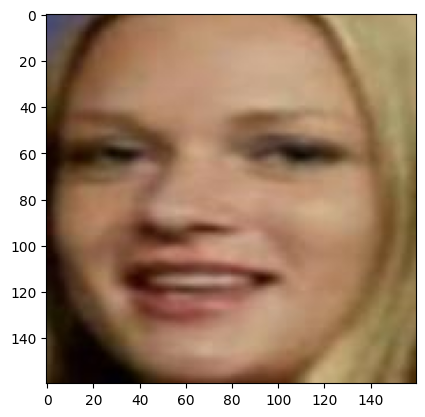

In [17]:
img = Image.open('../data/lfw-faces/AJ_Cook_0001.jpg')

plt.imshow(img)

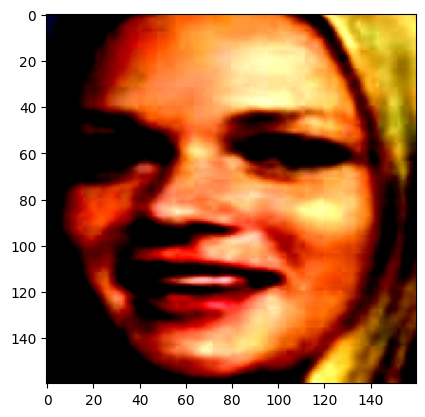

In [18]:
img = transform(img)
img = img.clamp(0, 1)
plt.imshow(img.permute(1, 2, 0))

In [23]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

img = img.to(device)
img_embedding = resnet(img.unsqueeze(0)).detach().cpu().numpy()

img_embedding.shape

(1, 512)

In [25]:
def extract_embeddings(model, train_df, transform, device) -> list:
    embeddings = []
    for i, row in tqdm(train_df.iterrows(), total=len(train_df)):
        img = Image.open(row['path'])
        img = transform(img).to(device)
        img_embedding = model(img.unsqueeze(0)).detach().cpu().numpy()
        embeddings.append(img_embedding)
    
    return embeddings

In [32]:
train_df = pd.read_csv('../data/lfw_train.csv')

train_df['path'] = train_df['path'].apply(lambda x: '.' + x)

In [33]:
embeddings = extract_embeddings(resnet, train_df, transform, device)

  0%|          | 0/12665 [00:00<?, ?it/s]

In [34]:
train_df['embedding'] = embeddings

In [36]:
train_df.to_pickle('../data/lfw_train_embeddings.pkl')